In [1]:
# add parent directory to path
import sys
sys.path.append('..')

from mdof_pinn import mdof_pinn_stoch, normalise, ParamClipper
import dynasim
from mdof_solutions import gen_ndof_cantilever, add_noise

import numpy as np
import torch

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS

import string
import findiff

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
checkpoint = torch.load('checkpoints/mdof_stoch_instance.pth')
data = checkpoint['data']
prediction = checkpoint['prediction']
ground_truth = checkpoint['ground_truth']
alphas = checkpoint['alphas']
pinn_config = checkpoint['config']

mdof_model = mdof_pinn_stoch(pinn_config)
mdof_model.set_colls_and_obs(data, prediction)

mdof_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

AB;CD;EF


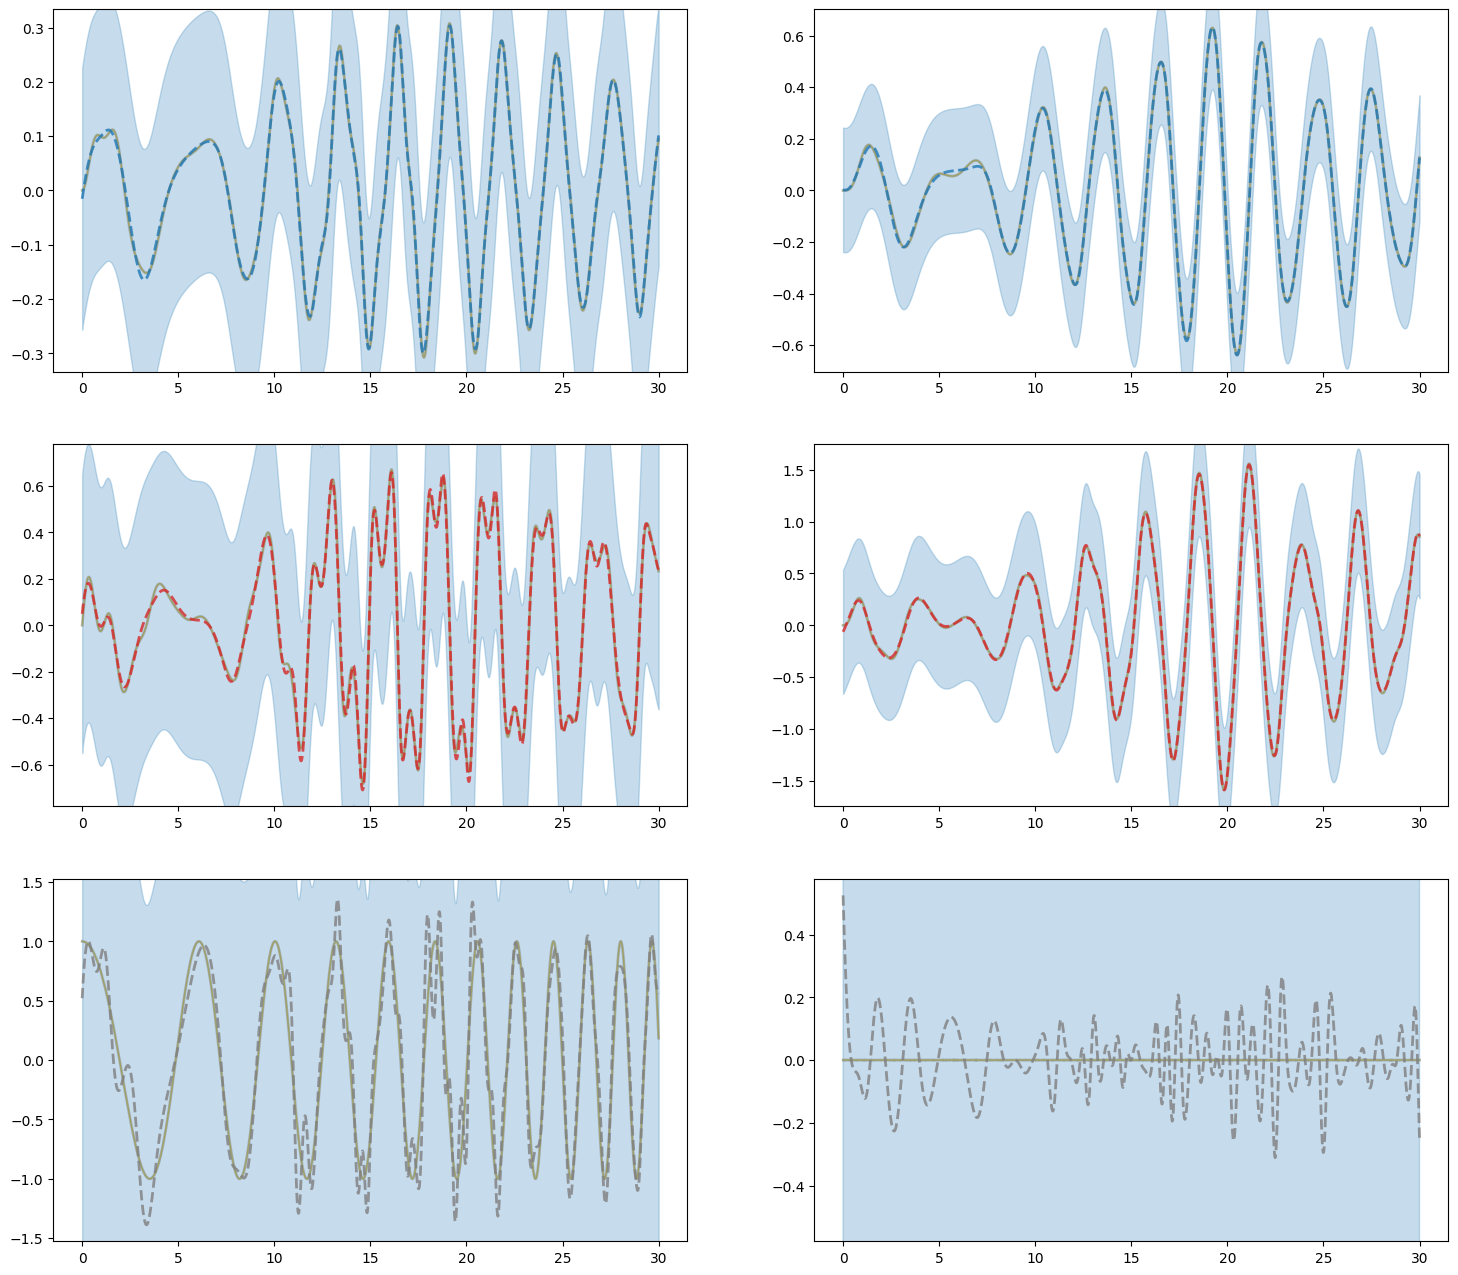

In [3]:
n_dof = pinn_config['n_dof']
if n_dof > 4:
    sub_rows = n_dof // 4 + int((n_dof%4)!=0)
    sub_cols = 4
else:
    sub_rows = 1
    sub_cols = n_dof

alphabet = list(string.ascii_uppercase)
mosaic_key = ''
alph_count = 0
for j in range(sub_rows):
    mosaic_key += ''.join(alphabet[alph_count:alph_count+sub_cols]) + ';' + ''.join(alphabet[alph_count+sub_cols:alph_count+2*sub_cols]) + ';' + ''.join(alphabet[alph_count+2*sub_cols:alph_count+3*sub_cols]) + ';'
    alph_count += 3*sub_cols
mosaic_key = mosaic_key[:-1]
print(mosaic_key)

def plot_result(axs_m, ground_truth, data, prediction, alphas):
    for ax in axs_m:
        axs_m[ax].cla()
    axs_top_list = []
    for j in range(sub_rows):
        axs_top_list.append([axs_m[alphabet[3*sub_cols*j+i]] for i in range(sub_cols)])
        axs_top_list.append([axs_m[alphabet[3*sub_cols*j+sub_cols+i]] for i in range(sub_cols)])
        axs_top_list.append([axs_m[alphabet[3*sub_cols*j+2*sub_cols+i]] for i in range(sub_cols)])
    axs_top = np.array(axs_top_list)

    plot_keys = ["x_hat", "v_hat", "F_hat"]
    plot_cols = ["tab:blue", "tab:red", "tab:gray"]
    alpha_keys = ["x", "v", "F"]
    p_count = 0
    for j in range(sub_rows):
        for i in range(sub_cols):
            for n in range(3):
                axs_top[j*3+n,i].plot(data["t_hat"].detach()*alphas["t"], data[plot_keys[n]][:,p_count].detach()*alphas[alpha_keys[n]], color="tab:olive", linewidth=1, alpha=0.8, label='Training data')
                axs_top[j*3+n,i].plot(ground_truth["t_hat"]*alphas["t"], ground_truth[plot_keys[n]][:,p_count]*alphas[alpha_keys[n]], color="grey", linewidth=2, alpha=0.5, label="Exact solution")
                axs_top[j*3+n,i].plot(prediction["t_hat"].detach()*alphas["t"], prediction[plot_keys[n]][:,p_count]*alphas[alpha_keys[n]], color=plot_cols[n], linewidth=2, alpha=0.8, linestyle='--', label="Neural network prediction")
                if n < 2:
                    axs_top[j*3+n,i].fill_between((prediction["t_hat"].detach()*alphas["t"]).squeeze(), (prediction[plot_keys[n]][:,p_count]-2*prediction['sigma'])*alphas[alpha_keys[n]], (prediction[plot_keys[n]][:,p_count]+2*prediction['sigma'])*alphas[alpha_keys[n]], alpha=0.25, color="tab:blue", label=r"$2\sigma$ Range")
                else:
                    axs_top[j*3+n,i].fill_between((prediction["t_hat"].detach()*alphas["t"]).squeeze(), (prediction[plot_keys[n]][:,p_count]-2*prediction['sigma_s'])*alphas[alpha_keys[n]], (prediction[plot_keys[n]][:,p_count]+2*prediction['sigma_s']), alpha=0.25, color="tab:blue", label=r"$2\sigma$ Range")
                xL = torch.amax(ground_truth["t_hat"])*alphas["t"]
                yL = torch.amax(torch.abs(prediction[plot_keys[n]][:,p_count]))*alphas[alpha_keys[n]]
                axs_top[j*2+n,i].set_xlim(-0.05*xL, 1.05*xL)
                axs_top[j*2+n,i].set_ylim(-1.1*yL, 1.1*yL)

            p_count += 1
            if p_count == n_dof:
                break

fig, axs = plt.subplot_mosaic(
    mosaic_key,
    figsize=(18,16),
    facecolor='w'
)

z_pred, f_pred = mdof_model.predict()

prediction["x_hat"] = z_pred.detach()[:,:n_dof]
prediction["v_hat"] = z_pred.detach()[:,n_dof:]
prediction["F_hat"] = f_pred.detach()
prediction['sigma'] = mdof_model.sigma_.detach()
prediction['sigma_s'] = mdof_model.sigma_s_.detach()

plot_result(axs, ground_truth, data, prediction, alphas)


In [7]:
def model(mdof_model):

    theta_s = pyro.sample('theta_s', dist.LogNormal(torch.zeros(mdof_model.n_dof), 0.5 * torch.ones(mdof_model.n_dof)))
    sigma_f = pyro.sample('sigma_f', dist.LogNormal(torch.zeros(mdof_model.n_dof), 0.5 * torch.ones(mdof_model.n_dof)))

    z_pred, f_pred = mdof_model.predict(theta_s)

    pyro.sample("force", dist.Normal(f_pred, sigma_f), obs=mdof_model.f_col*mdof_model.alpha_f)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel,
            num_samples = 1000,
            warmup_steps = 1000,
            num_chains = 4)
mcmc.run(mdof_model)


Warmup [1]:   0%|          | 0/2000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2000 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/2000 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/2000 [00:00, ?it/s]

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
  File "/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
  File "/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
  File "/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    exi

KeyboardInterrupt: 

In [6]:
import theano
import theano.tensor as tt

class TorchOp(tt.Op):

    def __init__(self, module, params, args=None):
        self.module = module
        self.params = list(params)
        if args is None:
            self.args = tuple()
        else:
            self.args = tuple(args)

    def make_node(self, *args):
        if len(args) != len(self.params):
            raise ValueError("dimensions mismatch")
        args = [tt.as_tensor_variable(a) for a in args]
        return theano.graph.basic.Apply(
            self, args, [tt.dscalar().type()] + [a.type() for a in args]
        )
    
    def infer_shape(self, *args):
        shapes = args[-1]
        return tuple([()]) + list(shapes)

    def perform(self, node, inputs, outputs):
        for p, value in zip(self.params, inputs):
            p.data = torch.tensor(value)
            if p.grad is not None:
                p.grad.detach()
                p.grad.zero_()
        
        result = self.module.physics_likelihood(*self.args)
        result.backward()

        outputs[0][0] = result.detach.numpy()
        for i, p in enumerate(self.params):
            outputs[i + 1][0] = p.grad.numpy()

    def grad(self, inputs, gradients):
        for i, g in enumerate(gradients[1:]):
            if not isinstance(g.type, theano.gradient.DisconnectedType):
                raise ValueError(
                    "can't propagate gradients wrt parameter {0}".format(i + 1)
                )
        return [gradients[0] * d for d in self(*inputs)[1:]]


model = torch.jit.script(mdof_model)

params = [model.c_, model.k_, model.kn_]

op = TorchOp(model, params)

import pymc3 as pm

with pm.Model() as torch_model:

    c_ = pm.LogNormal("c_", 0, 0.5)
    k_ = pm.LogNormal("k_", 0, 0.5)
    kn_ = pm.LogNormal("kn_", 0, 0.5)

    pm.Potential("phys", op(c_, k_, kn_))

    np.random.seed(6940)
    torch_trace = pm.sample(
        1000, tune=5000, target_accept=0.9, return_inferencedata=True, cores=1
    )

[autoreload of numpy.core.multiarray failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/numpy/core/multiarray.py", line 16, in <module>
    from ._multiarray_umath 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
The installed Theano(-PyMC) version (1.0.5) does not match the PyMC3 requirements.
It was imported from ['/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/theano']
For PyMC3 to work, a compatible Theano-PyMC backend version must be installed.
See https://github.com/pymc-devs/pymc3/wiki for installation instructions.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


AttributeError: 'TheanoConfigParser' object has no attribute '_config_var_dict'